In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [250]:
def plot_pretty(dpi=150,fontsize=5):
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in')
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5)
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5)
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    plt.rc('legend',fontsize=5)
    plt.rc('text',usetex=True)
    plt.rcParams['figure.figsize'] = [5, 2]

In [254]:
df = pd.read_csv("doge_data.csv")
df["timetrade"] = pd.to_datetime(df["timetrade"])
df["timenow"] = pd.to_datetime(df["timenow"])
avg_latency = np.mean(df["latency"])

In [255]:
plot_pretty(300)
start = 0
end = 200

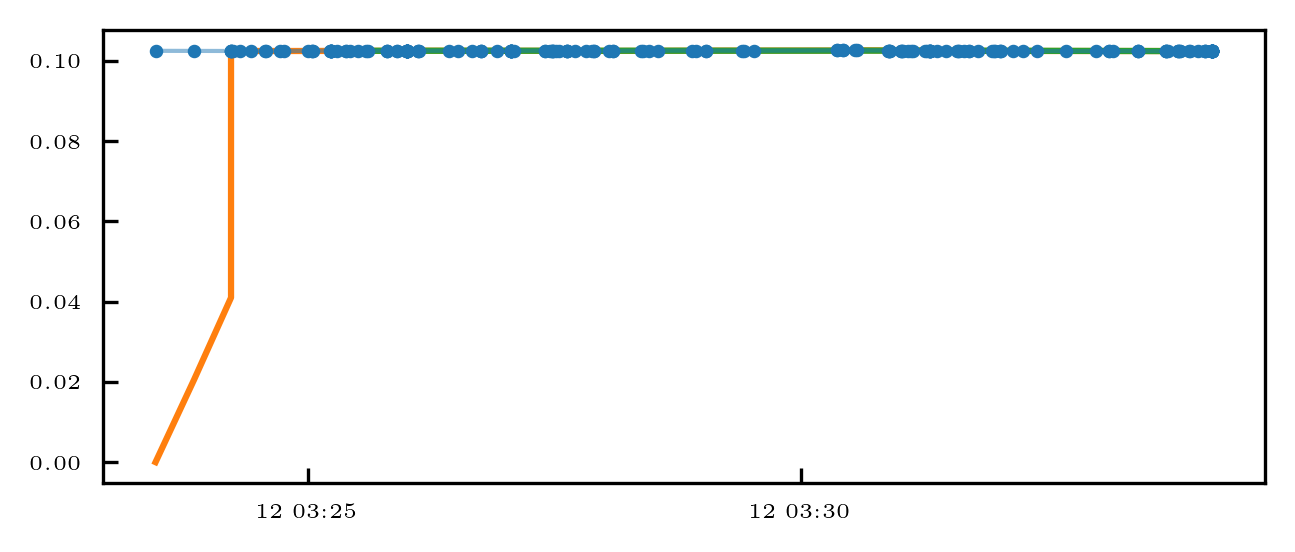

In [256]:
plt.plot(df["timetrade"][start:end],df["price"][start:end],linewidth=1,alpha=0.5)
plt.scatter(df["timetrade"][start:end],df["price"][start:end],s=5)
plt.plot(df["timetrade"][start:end],df["mvavg"][start:end],zorder=0)
plt.plot(df["timetrade"][start+20:end],df["longermvavgprice"][start+20:end],zorder=0)
#plt.xticks([df["timetrade"][start],df["timetrade"][end]],[str(df["timetrade"][start]).split(" ")[1],str(df["timetrade"][end]).split(" ")[1]])
#plt.plot(df["timetrade"],df["relmvavgdiff"])
plt.show()

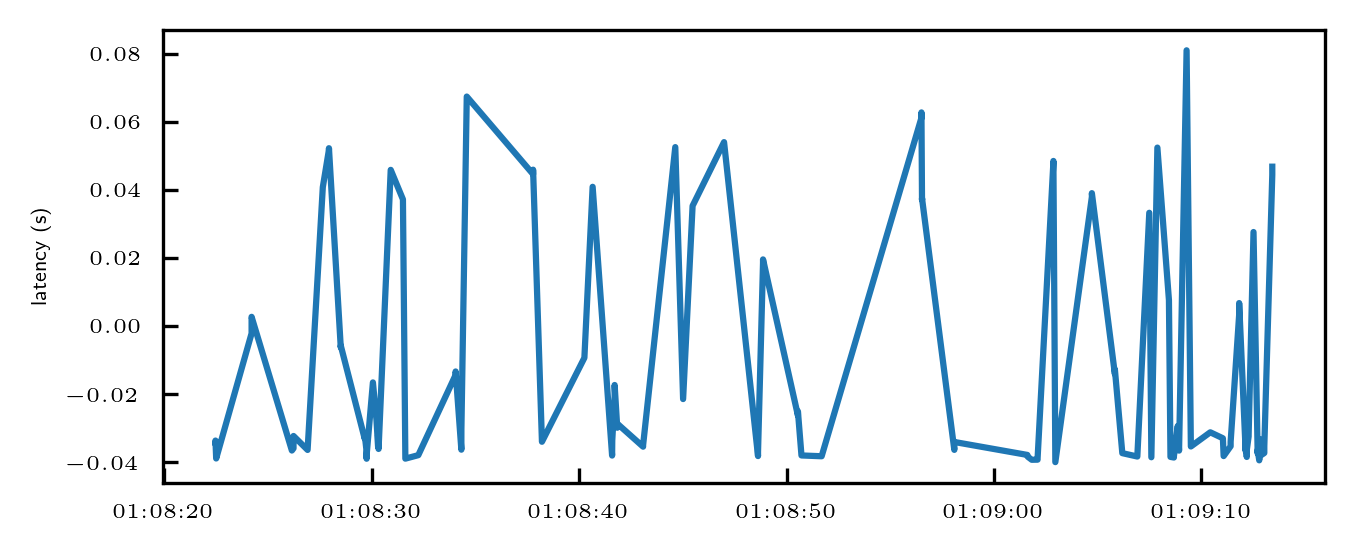

In [37]:
plot_pretty(300)
plt.plot(df["timetrade"][start:end],df["latency"][start:end] * 1e-9)
plt.ylabel("latency (s)")
#plt.scatter(df["timetrade"][start:end],df["price"][start:end],s=5)
#plt.plot(df["timetrade"][start:end],df["mvavg"][start:end],zorder=0)
#plt.xticks([df["timetrade"][start],df["timetrade"][end]],[str(df["timetrade"][start]).split(" ")[1],str(df["timetrade"][end]).split(" ")[1]])
#plt.plot(df["timetrade"],df["relmvavgdiff"])
plt.show()

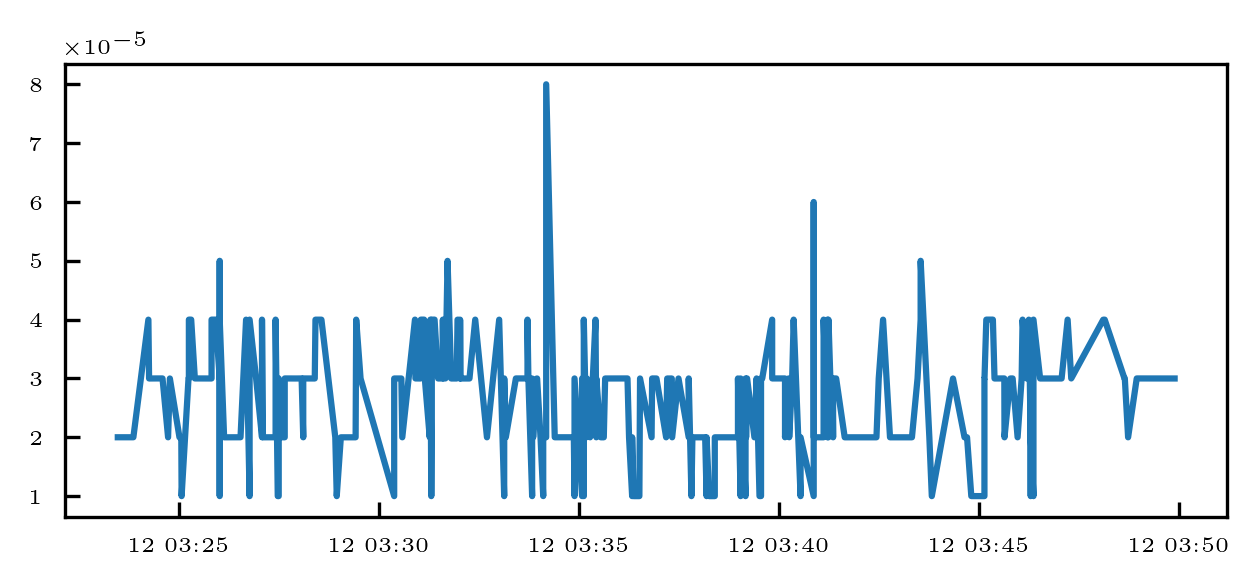

In [258]:
plot_pretty(300)
plt.plot(df["timetrade"],df["spread"])
#plt.ylabel("latency (s)")
#plt.scatter(df["timetrade"][start:end],df["price"][start:end],s=5)
#plt.plot(df["timetrade"][start:end],df["mvavg"][start:end],zorder=0)
#plt.xticks([df["timetrade"][start],df["timetrade"][end]],[str(df["timetrade"][start]).split(" ")[1],str(df["timetrade"][end]).split(" ")[1]])
#plt.plot(df["timetrade"],df["relmvavgdiff"])
plt.show()

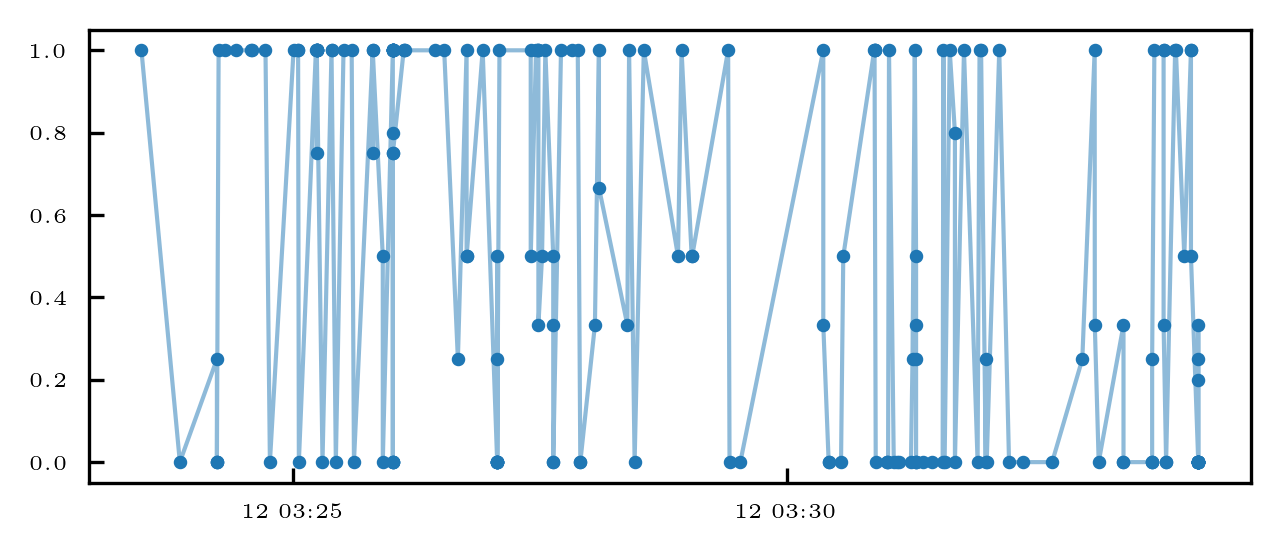

In [259]:
plt.plot(df["timetrade"][start:end],df["lerp"][start:end],linewidth=1,alpha=0.5)
plt.scatter(df["timetrade"][start:end],df["lerp"][start:end],s=5)
#plt.xticks([df["timetrade"][start],df["timetrade"][end]],[str(df["timetrade"][start]).split(" ")[1],str(df["timetrade"][end]).split(" ")[1]])
#plt.plot(df["timetrade"],df["relmvavgdiff"])
plt.show()

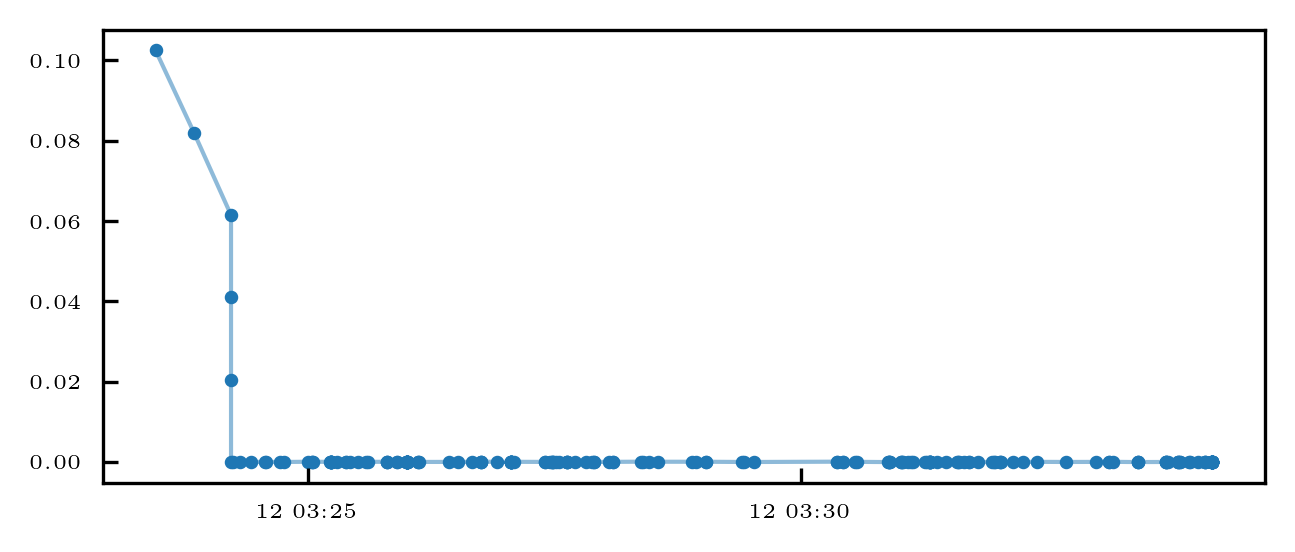

In [260]:
plt.plot(df["timetrade"][start:end],df["mvavgdiff"][start:end],linewidth=1,alpha=0.5)
plt.scatter(df["timetrade"][start:end],df["mvavgdiff"][start:end],s=5)
#plt.xticks([df["timetrade"][start],df["timetrade"][end]],[str(df["timetrade"][start]).split(" ")[1],str(df["timetrade"][end]).split(" ")[1]])
#plt.plot(df["timetrade"],df["relmvavgdiff"])
plt.show()

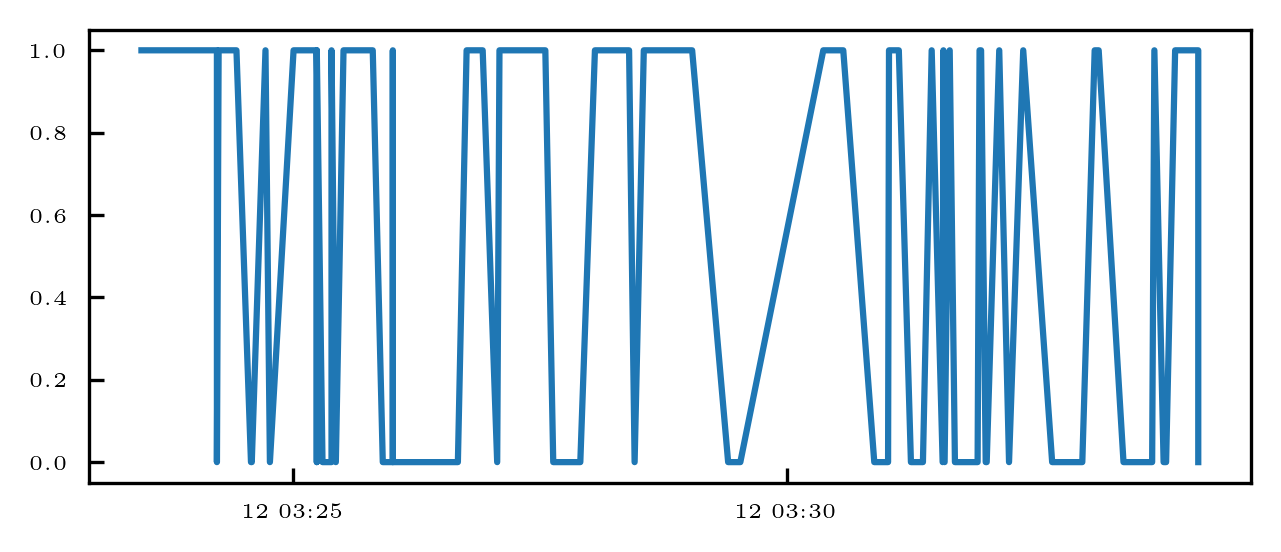

In [261]:
buy_now = df["mvavgdiff"] > 0
plt.plot(df["timetrade"][start:end],buy_now[start:end])
plt.show()

In [262]:
init_liquid = 0
current_liquidity = init_liquid

class BuyOrder:
    def __init__(self, send_time, time_out = 5, latency = avg_latency, target_profit = 1, trade_unit = 0.0001, fees = 0.01):
        #print("placed buy order at",send_time)
        self.send_time = send_time
        self.time_out = pd.to_timedelta(time_out,'s')
        self.bought = False
        self.bought_price = 0
        self.bought_time = 0
        self.sold = False
        self.sold_price = 0
        self.sold_time = 0
        self.total_fees = 0
        self.fees = fees
        self.sell_minimum_price = 0
        self.latency = pd.to_timedelta(latency,'ns')
        self.target_profit = target_profit
        self.trade_unit = trade_unit
        self.scratch = False
        self.scratch_time = 0

    def update(self, current_time, price):
        global current_liquidity
        if (not self.bought):
            if (current_time < (self.send_time + self.latency)):
                return
            self.bought = True
            self.bought_price = price
            self.bought_time = current_time
            self.sell_minimum_price = self.bought_price + self.target_profit * self.bought_price * self.trade_unit
            #print("sell min = ",self.sell_minimum_price,self.bought_price)
            current_liquidity -= price * self.trade_unit
            self.total_fees += price * self.trade_unit * self.fees
            #print("???",price * self.trade_unit * self.fees)
            #print("buy order filled at",current_time,"placing sell order")
            return
        if (self.bought and not self.sold):
            if (current_time < (self.bought_time + self.latency * 2)):
                return
            if ((price >= self.sell_minimum_price) and not (self.scratch and (current_time > (self.scratch_time + self.latency)))):
                self.sold = True
                self.sold_time = current_time
                self.sold_price = price
                current_liquidity += price * self.trade_unit
                self.total_fees += price * self.trade_unit * self.fees
                print("sell order success, profit = ",self.profit(),"at",current_time)
                return
            if (price <= self.bought_price) or (current_time > (self.bought_time + self.latency + self.time_out)):
                #if (current_time > (self.bought_time + self.latency + self.time_out)):
                #    print("scratching timeout at",current_time)
                #else:
                #    print("scratching price kill at",current_time)
                self.scratch = True
                self.scratch_time = current_time
            if (self.scratch):
                if (current_time > (self.scratch_time + self.latency)):
                    self.sold = True
                    self.sold_time = current_time
                    self.sold_price = price
                    current_liquidity += price * self.trade_unit
                    self.total_fees += price * self.trade_unit * self.fees
                    #print("sell order scratch executed, loss = ",self.profit(),"at",current_time)
                    return

    def profit(self):
        #print(self.total_fees)
        return (self.sold_price * self.trade_unit - self.bought_price * self.trade_unit) - self.total_fees

    def to_string(self):
        return f"PROFIT: {self.profit()} | (Bought:{self.bought}, price:{self.bought_price} (spent: {self.bought_price * self.trade_unit}), time:{self.bought_time}, sold:{self.sold}, price:{self.sold_price} (recvd: {self.sold_price * self.trade_unit}), time:{self.sold_time})"

fees = 0
target_profit = 0.01
timeout = 0.1
latency = avg_latency
trade_unit = 0.001
threshold = 3

buy_orders = []
liquids = []
for index, row in list(df.iterrows()):
    for i in buy_orders:
        i.update(row["timetrade"],row["price"])
    if (row["mvavgdiff"] > threshold):
        buy_orders.append(BuyOrder(row["timenow"],target_profit=target_profit,fees=fees,time_out=timeout,latency=latency,trade_unit=trade_unit))
    liquids.append(current_liquidity)
closed = []
closed_liquids = []
total_profit = 0
for i in buy_orders:
    if (not i.sold):
        break
    #print(i.to_string())
    closed.append(i)
    total_profit += i.profit()
for i in range(len(closed)):
    closed_liquids.append(liquids[i])
print(np.min(closed_liquids))
print(total_profit)

ValueError: zero-size array to reduction operation minimum which has no identity

In [263]:
trade_exec_time = (df["timenow"] + pd.to_timedelta(avg_latency,'ns')).to_numpy()
next_price_time = []
next_price = []
sell_price = []
max_hold_time = pd.to_timedelta(5,'s')
latency = pd.to_timedelta(avg_latency,'ns') * 1

target_profit = 1
buy_units = 0.012

liquidity_tracker = {}

buys = {}
sells = {}

for i in df["timetrade"]:
    buys[i] = False
    sells[i] = False

for i in trade_exec_time:
    for j,price,idx in zip(df["timetrade"][:-100],df["price"][:-100],range(len(df["timetrade"][:-100]))):
        if j > i:
            next_price_time.append(j)
            next_price.append(price * buy_units)
            if (j in liquidity_tracker):
                liquidity_tracker[j] += -price * buy_units
            else:
                liquidity_tracker[j] = -price * buy_units
            buys[j] = True
            added_price = False
            looking_for_profit = True
            scratch_time = 0
            for k,new_price in zip(df["timetrade"][idx+1:],df["price"][idx+1:]):
                if (k < (j + latency)):
                    continue
                if looking_for_profit:
                    if ((new_price - price) >= target_profit):
                        added_price = True
                        sell_price.append(new_price * buy_units)
                        if (j in liquidity_tracker):
                            liquidity_tracker[j] += new_price * buy_units
                        else:
                            liquidity_tracker[j] = new_price * buy_units
                        sells[i] = True
                        break
                else:
                    if (k >= (scratch_time + latency)):
                        added_price = True
                        sell_price.append(new_price * buy_units)
                        if (j in liquidity_tracker):
                            liquidity_tracker[j] += new_price * buy_units
                        else:
                            liquidity_tracker[j] = new_price * buy_units
                        sells[i] = True
                        break
                if (new_price < price):
                    looking_for_profit = False
                    scratch_time = k
                if (k > (j + max_hold_time)):
                    looking_for_profit = False
                    scratch_time = k
            if (not added_price):
                print("???")
                sell_price.append(0)
            break

sell_price = np.array(sell_price)
buy_price = np.array(next_price)

profit = np.sum(sell_price) - np.sum(buy_price)
print(profit)

liquidity = []
times = []
for i in sorted(liquidity_tracker):
    liquidity.append(liquidity_tracker[i])
    times.append(i)
print(liquidity)
print(times)

#next_price_time
#next_price
#profit
#plt.plot(sell_price - buy_price)

-5.520000000036607e-06
[-1.1999999999993786e-07, 0.0, -9.600000000003703e-07, 0.0, 0.0, -2.3999999999987573e-07, -2.3999999999987573e-07, 1.1999999999993786e-07, 8.399999999999987e-07, 2.4000000000009257e-07, 0.0, -4.799999999997515e-07, 0.0, 0.0, 0.0, 0.0, 7.200000000000609e-07, 3.599999999998136e-07, 0.0, 2.3999999999987573e-07, -1.1999999999993786e-07, -3.599999999998136e-07, -2.3999999999987573e-07, -2.1599999999988816e-06, -2.3999999999987573e-07, 0.0, 3.599999999998136e-07, 5.999999999999062e-07, -1.1999999999993786e-07, -1.439999999999905e-06, -2.3999999999987573e-07, 0.0, 2.3999999999987573e-07, -2.3999999999987573e-07, -3.6000000000003043e-07, -9.599999999999366e-07, -7.199999999996272e-07, -4.799999999999683e-07, -2.4000000000009257e-07, 0.0, -1.1999999999993786e-07, -1.1999999999993786e-07, 3.6000000000003043e-07, 1.439999999999688e-06, 5.999999999999062e-07, 7.199999999996272e-07, 0.0, 7.200000000000609e-07, 3.6000000000003043e-07, 2.4000000000009257e-07, 1.200000000001547e

0.00123036
0.00123024
0.00122988
0.00122976
0.00122976
0.00122976
0.0012301200000000001
0.00122988
0.00122988
0.00122988
0.00122988
0.0012301200000000001
0.0012296400000000002
0.00123024
0.0012304800000000002
0.0012304800000000002
0.00123072
0.0012304800000000002
0.0012304800000000002
0.0012304800000000002
0.0012304800000000002
0.0012304800000000002
0.0012306
0.0012306
0.0012306
0.0012306
0.0012301200000000001
0.0012304800000000002
0.0012304800000000002
0.0012301200000000001
0.0012304800000000002
0.00123084
0.0012304800000000002
0.00123084
0.00123084
0.0012309600000000001
0.00123072
0.0012304800000000002
0.00123072
0.00123072
0.00123072
0.00123072
0.00123072
0.00123072
0.00123072
0.00123084
0.00123084
0.00123084
0.00123084
0.00123084
0.00123084
0.00123084
0.00123084
0.00123084
0.00123084
0.00123084
0.0012306
0.0012306
0.0012306
0.0012304800000000002
0.0012304800000000002
0.0012304800000000002
0.00123084
0.00123084
0.0012309600000000001
0.00123108
0.00123072
0.00123072
0.00123072
0.0012

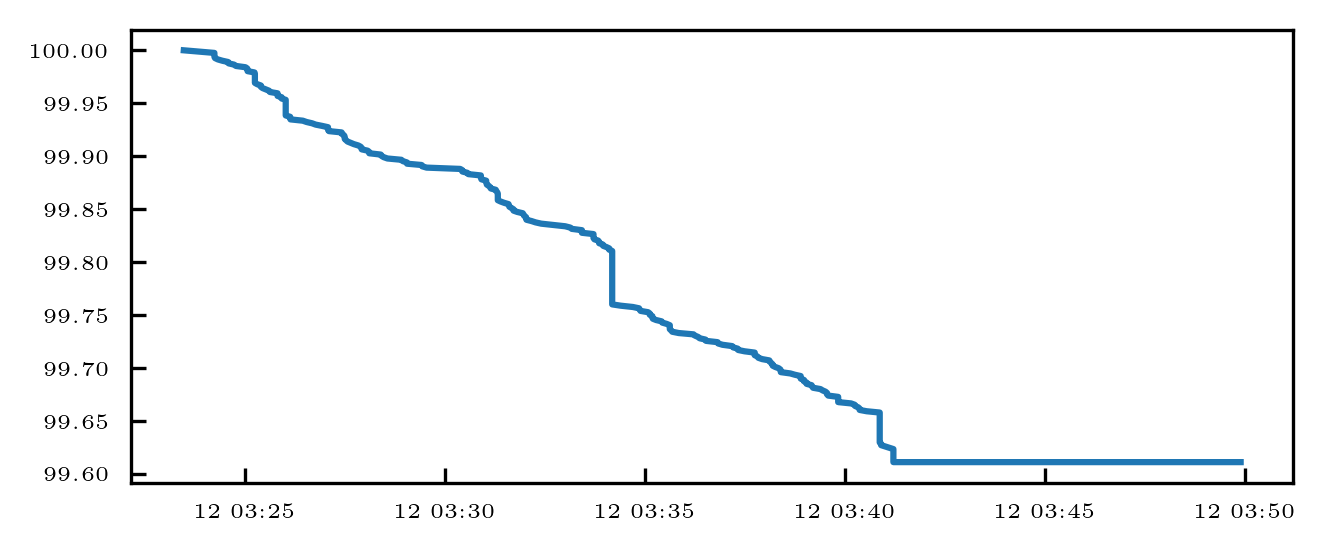

In [264]:
initial_liquid = 100
liquid = initial_liquid
liquids = []
for j,price in zip(df["timetrade"],df["price"]):
    print(price * buy_units)
    if (buys[j]):
        liquid -= price * buy_units
    if (sells[j]):
        liquid += price * buy_units
    liquids.append(liquid)
print(liquids)
plt.plot(df["timetrade"],liquids)
plt.show()